In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Create and use Vertex AI Persistent Resources using the Google Cloud CLI (gcloud)

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/jbrache/vertex-ai-persistent-resources/blob/main/00_Vertex_AI_Persistent_Resources_CLI_Example.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
</table>



This tutorial shows you how to leverage Vertex AI Persistent Resources to run custom training jobs.

Learn more about [Vertex AI Persistent Resources](https://cloud.google.com/vertex-ai/docs/training/persistent-resource-overview).

---

| | |
|----------|-------------|
| Author(s)   | Jose Brache (jbrache@) |
| Last updated | 09/30/2023 |

<br/>

| Release Notes||
|----------|-------------|
| Date   | Description |
| 09/30/2023 | Initial version |

### **<font color="grey">NOTE: THIS FEATURE IS PUBLIC PREVIEW.</font>**

1. Public Docs are available [here](https://cloud.google.com/vertex-ai/docs/training/create-persistent-cluster).
2. [gcloud support - beta](https://cloud.google.com/sdk/gcloud/reference/beta/ai/persistent-resources)
3. [REST API - beta](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/projects.locations.persistentResources#state)
4. [Vertex AI Python SDK - beta](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1beta1.services.persistent_resource_service)

![image.png](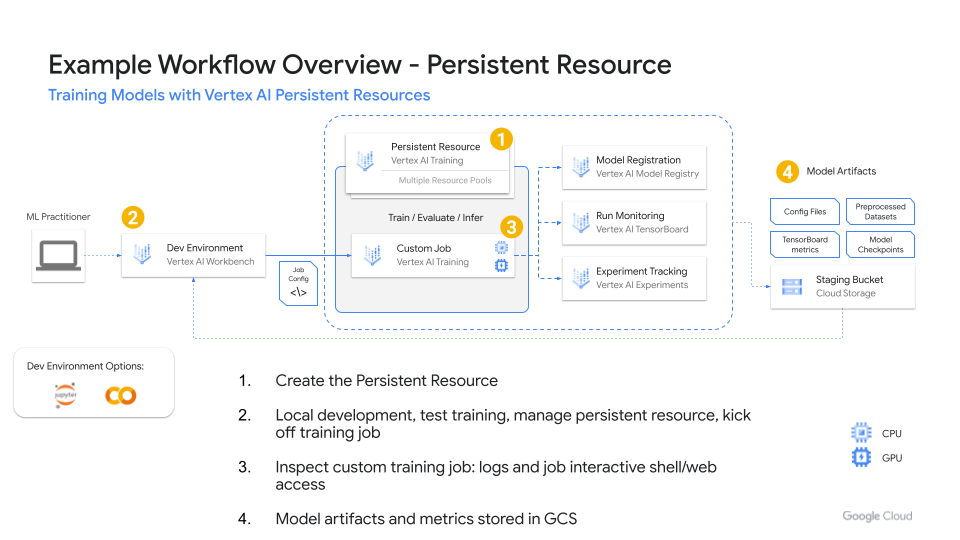
)

## Import libraries and define constants

In [ ]:
import sys

if "google.colab" in sys.modules:
    !pip3 install --upgrade google-cloud-aiplatform

    from google.colab import auth as google_auth
    google_auth.authenticate_user()

    # Restart the notebook kernel after installs.
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---

#### ⚠️ Do not forget to click the "RESTART RUNTIME" button above.

---

If you install additional packages, it's suggested to restart the notebook kernel so it can find the packages.

In [ ]:
# Ensure your gcloud is 438.0 or later, and it includes the `beta` component
!gcloud --version

# 0-0. Set up the project, import libraries and define constants

In [ ]:
import json
import logging
import traceback
import sys
import os

In [ ]:
############## Set Project ###########################
# The project needs to be added to the allowlist by Vertex Training team
# before moving ahead to the rest of this Colab
PROJECT_ID= '[your-project-id]' #@param {type:"string"}
REGION = 'us-central1' #@param {type:"string"}
BUCKET_NAME = f'gs://{PROJECT_ID}-persistent-resources'

############ Setting the Enviroment ###########
SERVICE ="aiplatform.googleapis.com"
ENDPOINT="us-central1-aiplatform.googleapis.com"

In [ ]:
IS_COLAB = "google.colab" in sys.modules

In [ ]:
!gcloud config set project $PROJECT_ID

In [ ]:
############# Enable the APIs ########################
# !gcloud services enable {SERVICE}
print('You may go to the below uri and to ensure the API is enabled.')
print('https://console.cloud.google.com/apis/library/{}?project={}'.format(SERVICE, PROJECT_ID))

## 0-1. Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
!gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

## 0-2. Training Code Container

In [ ]:
if IS_COLAB:
  !git clone https://github.com/jbrache/vertex-ai-persistent-resources.git

In [ ]:
# Training code container def
if IS_COLAB:
  CONTAINER_DIR = "vertex-ai-persistent-resources/training_code/mpg_container"
else:
  CONTAINER_DIR = "training_code/mpg_container"

In [ ]:
# Print the location where the training code exists, will be used to create the artifact registry container
print(f"Local container directory with training code: {CONTAINER_DIR}")
print("Check whether the container directory exists:", os.path.exists(CONTAINER_DIR))

In [ ]:
# Repo to create / use for running training job
PRIVATE_REPO = "mpg-training"
TRAIN_IMAGE = (
    f"{REGION}-docker.pkg.dev/" + PROJECT_ID + f"/{PRIVATE_REPO}" + "/tf-mpg-training:latest"
)
print("Private Repo:", PRIVATE_REPO)
print("Training Container Image:", TRAIN_IMAGE)

## 0-3. Persistent Resource

In [ ]:
# You may first check the general help info of the command usage.
# !gcloud beta ai persistent-resources create --help

In [ ]:
### Name your Persistent Resource
PERSISTENT_RESOURCE_ID='preview-pr-autoscaling-gcloud-1' #@param {type:"string"}

In [ ]:
# @title Resource Pool Spec Definition
############ Set Resource Pool Spec #####################
#
# Edit the cluster config below if you want.
#
# Note that, if you specify any GPU pool, please ensure that the machine type
# is compatible with the accelerator type, for example, A100 GPU can only work
# on A2 machine types.
# See more detalis in https://cloud.google.com/compute/docs/gpus#nvidia_gpus_for_compute_workloads

CPU_MACHINE_TYPE =  "n1-standard-4" #@param {type:"string"}
CPU_REPLICA_COUNT = 1 # @param {type:"integer"}
CPU_MIN_REPLICA_COUNT = 1 # @param {type:"integer"}
CPU_MAX_REPLICA_COUNT = 4 # @param {type:"integer"}

In [ ]:
# https://cloud.google.com/sdk/gcloud/reference/beta/ai/persistent-resources
# https://cloud.google.com/vertex-ai/docs/training/persistent-resource-create
PR_CONFIG = f"""
resourcePools:
  - machineSpec:
      machineType: {CPU_MACHINE_TYPE}
    replicaCount: {CPU_REPLICA_COUNT}
    autoscalingSpec:
      minReplicaCount: {CPU_MIN_REPLICA_COUNT}
      maxReplicaCount: {CPU_MAX_REPLICA_COUNT}
    diskSpec:
      bootDiskType: pd-ssd
      bootDiskSizeGb: 100
"""

In [ ]:
f = open("config.yaml", "w")
f.write(PR_CONFIG[1:])
f.close()

!cat config.yaml

# 1-0. Create a PersistentResource with Autoscaling

Let's create a PersistentResource with one CPU pool with Autoscaling.

Make the request to create your Persistent Resource

In [ ]:
!gcloud beta ai persistent-resources create \
    --persistent-resource-id={PERSISTENT_RESOURCE_ID} \
    --region={REGION} \
    --display-name={PERSISTENT_RESOURCE_ID} \
    --config=config.yaml

Check PresistentResource Creation LRO status and wait is shows `done: true`

In [ ]:
# @title Get persistent resource details
# Copy the operation number printed above here
OPERATION_NUMBER = "" #@param {type:"string"}
CREATION_OPERATION = f'projects/{PROJECT_ID}/locations/{REGION}/operations/{OPERATION_NUMBER}'
!gcloud beta ai operations describe {CREATION_OPERATION}

In [ ]:
# Check the general help info about how to list all the persistent resources
# !gcloud beta ai persistent-resources list --help

In [ ]:
# @title List all the persistent resources under your project
!gcloud beta ai persistent-resources list --region={REGION}

In [ ]:
# Check the general help info about how to get a specifc persistent resource
# !gcloud beta ai persistent-resources describe --help

In [ ]:
# @title View details about your persistent resource
!gcloud beta ai persistent-resources describe {PERSISTENT_RESOURCE_ID} --region={REGION}

# 2-0. Run CustomJobs on the PersistentResource

## Enable Artifact Registry API
You must enable the Artifact Registry API for your project. You will store your custom training container in Artifact Registry.

<a href="https://cloud.google.com/artifact-registry/docs/enable-service">Learn more about Enabling service</a>.

In [ ]:
!gcloud services enable artifactregistry.googleapis.com

### Create a private Docker repository
Your first step is to create a Docker repository in Artifact Registry.

1 - Run the `gcloud artifacts repositories create` command to create a new Docker repository with your region with the description `docker repository`.

2 - Run the `gcloud artifacts repositories list` command to verify that your repository was created.

In [ ]:
print("Private Repo:", PRIVATE_REPO)
print("Deployment:", TRAIN_IMAGE)

In [ ]:
!gcloud artifacts repositories create {PRIVATE_REPO} --repository-format=docker --location={REGION} --description="Docker repository"

In [ ]:
!gcloud artifacts repositories list

## 2-1. Build and push the custom docker container image by using Cloud Build

Build and push a Docker image with Cloud Build

In [ ]:
!cd $CONTAINER_DIR && gcloud builds submit --timeout=1800s --region={REGION} --tag $TRAIN_IMAGE

## 2-2. Prepare training jobs

We support submiting custom training job with prebuilt container, custom container and python application via **HTTP request, Vertex AI SDK or gcloud CLI**. Learn more [here](https://cloud.google.com/vertex-ai/docs/training/code-requirements)

In this example, we will demonstrate how to run custom job with with custom container. Please specify the images below to your custom images.
Note, if it's not a public image, please ensure it's already pushed to your project.

https://cloud.google.com/vertex-ai/docs/training/containers-overview

In [ ]:
# Prepare training images
CPU_IMAGE = TRAIN_IMAGE
JOB_DIR = BUCKET_NAME
print("Using image: ", CPU_IMAGE)
print("Output Model Directory: ", JOB_DIR)

In [ ]:
############ Set WorkerPool Spec #####################
# https://cloud.google.com/sdk/gcloud/reference/beta/ai/custom-jobs/create
CONTENT=f"""
workerPoolSpecs:
  - machineSpec:
      machineType: n1-standard-4
    replicaCount: 1
    containerSpec:
      imageUri: {CPU_IMAGE}
      args:
        --job-dir={JOB_DIR}
persistentResourceId: {PERSISTENT_RESOURCE_ID}
"""

In [ ]:
f = open("custom_job_spec.yaml", "w")
f.write(CONTENT[1:])
f.close()

!cat custom_job_spec.yaml

## 2-3. Create single-replica CPU jobs

In [ ]:
### Create A Single CPU node Training Job
!gcloud beta ai custom-jobs create \
    --region={REGION} \
    --display-name="Single CPU Job" \
    --config=custom_job_spec.yaml \
    --labels presistent_resource_job=true

## 2-4. Get single-replica CPU job status

In [ ]:
# Option 1: Use the Custom Job ID to get details
# JOB_ID = "" # @param {type:"string"}
# !gcloud beta ai custom-jobs describe {JOB_ID} --project={PROJECT_ID} --region={REGION}

In [ ]:
# Option 2: List existing custom jobs, filter running jobs and ones with the set label
# Lists the existing custom jobs, filters with the label set for these jobs
FILTER='"(state!="JOB_STATE_SUCCEEDED" AND state!="JOB_STATE_FAILED" AND state!="JOB_STATE_CANCELLED") AND labels.presistent_resource_job=true"'
!gcloud beta ai custom-jobs list --project={PROJECT_ID} --region={REGION} --filter={FILTER}

# 3-0. Test Autoscaling
This section tests autoscalling. Steps run below:
1. Check there are no used replicas on the persistent resource.
2. Kick off 4 Single CPU Replica custom training jobs on the persistent resource.
3. Get the persistent resource details to inspect used replicas.
4. You can also inspect the running jobs in Vertex AI Training

In [ ]:
# @title 3.1 Check usedReplicaCount on the persistent resource
# If usedReplicaCount is not shown, you're good to go. If you see usedReplicaCount >=1 a job is still running
!gcloud beta ai persistent-resources describe {PERSISTENT_RESOURCE_ID} --region={REGION}

In [ ]:
# @title 3.2 Start 4 Single CPU Replica Jobs
# Kick of 4 Single CPU Replica jobs, the cluster should scale up to maxReplicaCount of 4
for i in range(1, 5):
  print(f"Kicking off job {i}")
  !gcloud beta ai custom-jobs create \
    --region={REGION} \
    --display-name="Single CPU Job" \
    --config=custom_job_spec.yaml \
    --labels presistent_resource_job=true

In [ ]:
############# Check Vertex AI Training Custom Jobs ########################
print('You may go to the below uri to check submitted jobs.')
print(f'https://console.cloud.google.com/vertex-ai/training/custom-jobs?project={PROJECT_ID}')

In [ ]:
# @title 3.3 Get persistent resource details
# Check the usedReplicaCount field on the persistent resource
!gcloud beta ai persistent-resources describe {PERSISTENT_RESOURCE_ID} --region={REGION}

In [ ]:
# @title 3.4 Get active jobs on the persistent resource
FILTER='"(state!="JOB_STATE_SUCCEEDED" AND state!="JOB_STATE_FAILED" AND state!="JOB_STATE_CANCELLED") AND labels.presistent_resource_job=true"'
!gcloud beta ai custom-jobs list --project={PROJECT_ID} --region={REGION} --filter={FILTER}

# 4-0. Cleaning up

You may delete the PersistentResource created above anytime when you don't need it. To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Cloud Storage Bucket
- Artifacts Repository
- Vertex AI Persistent Resource

In [ ]:
# General help info about how to delete a persistent resource
# !gcloud beta ai persistent-resources delete --help

In [ ]:
# Set this to true only if you'd like to delete your bucket
delete_bucket = False
delete_artifacts_repo = False
delete_persistent_cluster = True

if delete_bucket:
  !gsutil rm -rf $JOB_DIR
  !gsutil rm -r $BUCKET_URI

if delete_persistent_cluster:
  !gcloud beta ai persistent-resources delete {PERSISTENT_RESOURCE_ID} --region={REGION}

if delete_artifacts_repo:
  !gcloud artifacts repositories delete {PRIVATE_REPO} --location={REGION} --quiet

## 4-1 List all Persistent Resources
Get list of persistent resources to make sure they're deleted

In [ ]:
# List all the persistent resources under your project
!gcloud beta ai persistent-resources list --region={REGION}